# Исследование с учетом разницы между чистым и адверсариальным примерами

# Определение функций

## Импорты и вспомогательные функции для отрисовки

### Что делаем:

Готовим инструменты для (1) локализации патча по разнице изображений и (2) сопоставления детекций.

### Зачем:

Для «гетерогенности успеха» критично локализовать вмешательство (патч) и сопоставлять объекты между clean и patched.

IoU/matching нужен, чтобы понять: «тот же объект» пропал или просто сдвинулся.

### Откуда идея в литературе:

Thys 2019 (зависимость эффективности от положения патча), Saha 2020 (влияние патча даже при малом перекрытии), бенчмарки/анализы патчей (пространственные эффекты).

In [8]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import math
import numpy as np
import torch
from PIL import Image

import matplotlib.pyplot as plt


# -------------------------
# Image conversions
# -------------------------

def pil_to_np_bgr(pil: Image.Image) -> np.ndarray:
    """PIL RGB -> np.uint8 BGR (H,W,3) for ultralytics predictor preprocess."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    rgb = np.asarray(pil)  # uint8 RGB
    bgr = rgb[..., ::-1].copy()
    return bgr


def pil_to_torch_rgb01(pil: Image.Image) -> torch.Tensor:
    """PIL -> torch float32 RGB in [0,1], shape [3,H,W] (CPU)."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    arr = np.asarray(pil).astype(np.float32) / 255.0
    t = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
    return t


# -------------------------
# Patch application
# -------------------------

def apply_patch_to_image(
    base_pil: Image.Image,
    patch_pil: Image.Image,
    position_xy: Tuple[int, int] = (0, 0),
) -> Tuple[Image.Image, Optional[torch.Tensor], int]:
    """Paste patch onto base image at (x,y). Returns patched PIL, bbox_xyxy, area_px."""
    if base_pil.mode != "RGB":
        base_pil = base_pil.convert("RGB")
    if patch_pil.mode != "RGB":
        patch_pil = patch_pil.convert("RGB")
    base_w, base_h = base_pil.size
    patch_w, patch_h = patch_pil.size
    x, y = position_xy
    x1 = max(0, int(x))
    y1 = max(0, int(y))
    x2 = min(base_w, int(x) + patch_w)
    y2 = min(base_h, int(y) + patch_h)
    if x2 <= x1 or y2 <= y1:
        return base_pil.copy(), None, 0
    # Crop patch if it spills outside the base image.
    px1 = x1 - int(x)
    py1 = y1 - int(y)
    px2 = px1 + (x2 - x1)
    py2 = py1 + (y2 - y1)
    patch_crop = patch_pil.crop((px1, py1, px2, py2))
    out = base_pil.copy()
    out.paste(patch_crop, (x1, y1))
    bbox = torch.tensor([float(x1), float(y1), float(x2), float(y2)], dtype=torch.float32)
    area = int((x2 - x1) * (y2 - y1))
    return out, bbox, area


def show_patch_bbox(clean_rgb01: torch.Tensor, patched_rgb01: torch.Tensor, patch_bbox: Optional[torch.Tensor]) -> None:
    def imshow_rgb(t: torch.Tensor, ax, title: str):
        ax.imshow(t.detach().cpu().permute(1, 2, 0).numpy().clip(0, 1))
        ax.set_title(title)
        ax.axis("off")

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    imshow_rgb(clean_rgb01, axs[0], "Clean")
    imshow_rgb(patched_rgb01, axs[1], "Patched")

    if patch_bbox is not None:
        x1, y1, x2, y2 = patch_bbox.tolist()
        for ax in axs:
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2))
    plt.tight_layout()
    plt.show()

# -------------------------
# Box utilities
# -------------------------

def box_iou_xyxy(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """IoU between sets of boxes in xyxy format. a[N,4], b[M,4] -> [N,M]."""
    if a.numel() == 0 or b.numel() == 0:
        return torch.zeros((a.shape[0], b.shape[0]), device=a.device, dtype=a.dtype)

    tl = torch.maximum(a[:, None, :2], b[None, :, :2])
    br = torch.minimum(a[:, None, 2:], b[None, :, 2:])
    wh = (br - tl).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]

    area_a = (a[:, 2] - a[:, 0]).clamp(min=0) * (a[:, 3] - a[:, 1]).clamp(min=0)
    area_b = (b[:, 2] - b[:, 0]).clamp(min=0) * (b[:, 3] - b[:, 1]).clamp(min=0)

    union = area_a[:, None] + area_b[None, :] - inter
    return inter / union.clamp(min=1e-9)


def greedy_match_by_iou(boxes_a: torch.Tensor, boxes_b: torch.Tensor, iou_thr: float = 0.5) -> List[Tuple[int, int, float]]:
    """Greedy IoU matching: returns list of (i_in_a, j_in_b, iou)."""
    iou = box_iou_xyxy(boxes_a, boxes_b)
    pairs: List[Tuple[int, int, float]] = []
    if iou.numel() == 0:
        return pairs

    used_a, used_b = set(), set()
    flat = []
    for i in range(iou.shape[0]):
        for j in range(iou.shape[1]):
            flat.append((i, j, float(iou[i, j].item())))
    flat.sort(key=lambda x: x[2], reverse=True)

    for i, j, v in flat:
        if v < iou_thr:
            break
        if i in used_a or j in used_b:
            continue
        used_a.add(i)
        used_b.add(j)
        pairs.append((i, j, v))
    return pairs


# -------------------------
# Patch localization by diff
# -------------------------

def estimate_patch_region_from_diff(
    clean_rgb01: torch.Tensor,
    patched_rgb01: torch.Tensor,
    diff_thr: float = 0.08,
    min_pixels: int = 50,
) -> Dict[str, Any]:
    """
    Estimate patch region via abs-diff thresholding.
    Returns:
      diff_map: [H,W] float
      mask: [H,W] bool
      bbox_xyxy: torch.Tensor[4] or None
      area_px: int
    """
    assert clean_rgb01.shape == patched_rgb01.shape
    diff = (patched_rgb01 - clean_rgb01).abs().mean(dim=0)  # [H,W]
    mask = diff > diff_thr
    area = int(mask.sum().item())
    bbox = None
    if area >= min_pixels:
        ys, xs = mask.nonzero(as_tuple=True)
        x1 = float(xs.min().item())
        x2 = float(xs.max().item() + 1)
        y1 = float(ys.min().item())
        y2 = float(ys.max().item() + 1)
        bbox = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)
    return {"diff_map": diff, "mask": mask, "bbox_xyxy": bbox, "area_px": area}


def show_patch_diff(clean_rgb01: torch.Tensor, patched_rgb01: torch.Tensor, patch_info: Dict[str, Any]) -> None:
    diff = patch_info["diff_map"].detach().cpu().numpy()
    mask = patch_info["mask"].detach().cpu().numpy()
    bbox = patch_info["bbox_xyxy"]

    def imshow_rgb(t: torch.Tensor, ax, title: str):
        ax.imshow(t.detach().cpu().permute(1, 2, 0).numpy().clip(0, 1))
        ax.set_title(title)
        ax.axis("off")

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    imshow_rgb(clean_rgb01, axs[0], "Clean")
    imshow_rgb(patched_rgb01, axs[1], "Patched")
    axs[2].imshow(diff); axs[2].set_title("Abs diff (mean C)"); axs[2].axis("off")
    axs[3].imshow(mask); axs[3].set_title("Diff mask"); axs[3].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox.tolist()
        for ax in axs:
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2))
    plt.tight_layout()
    plt.show()

## Логика, связанная с предсказаниями

### Что делаем:

Инициализируем predictor (Ultralytics).

Получаем:

im — тензор после preprocess (letterbox+нормировка),

raw — сырые предсказания модели (до NMS),

post — финальные боксы после Ultralytics NMS,

candidates — «почти pre-NMS» боксы через вызов Ultralytics NMS с iou_thres=1.0.

### Зачем:

Различать “score suppression” (candidate есть, но ниже conf) от “NMS suppression” (candidate есть и выше conf, но выкинут перекрывающимся конкурентом).

Именно это разделение очень часто упоминается как источник «нестабильности по изображениям».

### Откуда идея в литературе:

DPatch 2019: патч как приманка → много сильных ложных кандидатов.

Daedalus 2022: атаки на пост-обработку и поведение NMS.

Аналитические бенчмарки 2022–2023: необходимость смотреть pre-NMS/порог/NMS раздельно.

In [9]:

def load_ultralytics_yolo(weights: str):
    """Convenience loader. Example: 'yolo11n.pt' or your custom .pt."""
    from ultralytics import YOLO
    return YOLO(weights)


def ensure_predictor(yolo, imgsz: int = 640, conf: float = 0.25, iou: float = 0.45, device: Optional[str] = None):
    """
    Ultralytics lazily creates a predictor; we force initialization via a dummy predict.

    Why:
    - We need access to predictor.preprocess() and predictor.postprocess() for a consistent pipeline.
    """
    if getattr(yolo, "predictor", None) is None:
        dummy = np.zeros((imgsz, imgsz, 3), dtype=np.uint8)
        _ = yolo.predict(source=dummy, imgsz=imgsz, conf=conf, iou=iou, device=device, verbose=False)

    yolo.predictor.args.imgsz = imgsz
    yolo.predictor.args.conf = conf
    yolo.predictor.args.iou = iou

    if device is not None:
        yolo.predictor.device = torch.device(device)
        yolo.predictor.model.to(device)

    return yolo.predictor


def get_ultralytics_raw_preds_and_im(
    yolo,
    pil: Image.Image,
    imgsz: int = 640,
    conf: float = 0.25,
    iou: float = 0.45,
    device: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Returns:
      orig_bgr: np.ndarray(H,W,3)
      im: torch.Tensor(1,3,h,w) after Ultralytics preprocess
      raw: raw model outputs (before NMS)
      predictor: Ultralytics predictor

    Why:
    - raw is required for pre-NMS analysis and alternative postprocessing.
    - im is required for consistent scaling back to original image coordinates.
    """
    predictor = ensure_predictor(yolo, imgsz=imgsz, conf=conf, iou=iou, device=device)

    orig_bgr = pil_to_np_bgr(pil)
    im = predictor.preprocess([orig_bgr])
    with torch.no_grad():
        raw = predictor.inference(im)
    return {"orig_bgr": orig_bgr, "im": im, "raw": raw, "predictor": predictor}


def ultralytics_post_nms_from_raw(
    predictor,
    raw_preds: torch.Tensor,
    im: torch.Tensor,
    orig_bgr: np.ndarray,
) -> Dict[str, Any]:
    """
    Uses Ultralytics official postprocess (includes NMS + scaling) to get final detections.

    Why:
    - This is the “ground truth” of what the user typically sees.
    - We compare it against our pre-NMS candidates and traced NMS.
    """
    results = predictor.postprocess(raw_preds, im, [orig_bgr])
    r0 = results[0]
    boxes = r0.boxes.xyxy
    scores = r0.boxes.conf
    labels = r0.boxes.cls.long()
    return {"boxes": boxes, "scores": scores, "labels": labels, "results_obj": r0}


def ultralytics_candidates_no_suppression(
    raw_preds: torch.Tensor,
    conf_thres: float = 0.001,
    max_det: int = 30000,
    nc: int = 0,
    rotated: bool = False,
    end2end: bool = False,
) -> torch.Tensor:
    """
    Produces a large set of candidates by running Ultralytics NMS with iou_thres=1.0
    (effectively no suppression). This approximates “pre-NMS candidates”.

    Why:
    - We want to know whether the target existed among candidates at all.
    - We want to later trace how NMS removes candidates.
    """
    from ultralytics.utils import nms as ul_nms
    out = ul_nms.non_max_suppression(
        raw_preds,
        conf_thres=conf_thres,
        iou_thres=1.0,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=max_det,
        nc=nc,
        rotated=rotated,
        end2end=end2end,
        return_idxs=False,
    )
    return out[0] if len(out) else torch.zeros((0, 6), device=raw_preds.device)


def scale_boxes_to_original(
    boxes_xyxy: torch.Tensor,
    im_shape_hw: Tuple[int, int],
    orig_shape_hw: Tuple[int, int],
) -> torch.Tensor:
    """
    Scales xyxy from model input coords to original image coords using Ultralytics ops.

    Why:
    - Matching and patch-overlap must be done in original image space.
    """
    from ultralytics.utils import ops
    scaled = boxes_xyxy.clone()
    scaled[:, :4] = ops.scale_boxes(im_shape_hw, scaled[:, :4], orig_shape_hw)
    return scaled


def split_cand(c: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Candidate tensor (N,6) -> boxes(N,4), scores(N), labels(N)."""
    if c.numel() == 0:
        dev = c.device
        return (
            torch.zeros((0, 4), device=dev),
            torch.zeros((0,), device=dev),
            torch.zeros((0,), dtype=torch.long, device=dev),
        )
    return c[:, :4], c[:, 4], c[:, 5].long()

## NMS с трассировкой подавлений (кто кого подавил)

### Что делаем:

Реализуем NMS, которая возвращает не только kept boxes, но и список событий вида:

какой кандидат подавлен,

кем подавлен,

IoU и сравнение score.

### Зачем:

Это прямой инструмент, чтобы различить “провал из-за NMS” от “провал из-за feature/score suppression”.

Также позволяет понять паттерн “патч как приманка”: если подавляющие боксы часто расположены внутри bbox патча.

### Откуда идея в литературе:

Daedalus 2022: эффекты атаки на NMS/фильтрацию.

DPatch 2019: ложные детекции конкурируют с целевыми.

Бенчмарки/аналитика 2022: необходимость объяснять исчезновение объекта через post-processing.

In [10]:
@dataclass
class NMSSuppressionEvent:
    suppressed_idx: int
    kept_idx: int
    iou: float
    suppressed_score: float
    kept_score: float
    suppressed_cls: int
    kept_cls: int


def nms_with_trace(
    boxes_xyxy: torch.Tensor,
    scores: torch.Tensor,
    clses: torch.Tensor,
    iou_thr: float,
    class_aware: bool = True,
    max_det: int = 300,
) -> Tuple[torch.Tensor, List[NMSSuppressionEvent]]:
    """
    Deterministic NMS with suppression trace.

    Returns:
      kept_indices: indices into original candidate arrays
      events: list of suppression events

    Notes:
    - This is a simplified NMS; later we can align it exactly with Ultralytics by using return_idxs=True
      in ultralytics.utils.nms.non_max_suppression.
    """
    if boxes_xyxy.numel() == 0:
        return torch.empty((0,), dtype=torch.long, device=boxes_xyxy.device), []

    order = scores.argsort(descending=True)
    boxes = boxes_xyxy[order]
    scr = scores[order]
    cls = clses[order]

    keep_local: List[int] = []
    events: List[NMSSuppressionEvent] = []

    suppressed = torch.zeros((boxes.shape[0],), dtype=torch.bool, device=boxes.device)

    for i in range(boxes.shape[0]):
        if suppressed[i]:
            continue
        keep_local.append(i)
        if len(keep_local) >= max_det:
            break

        rest = torch.arange(i + 1, boxes.shape[0], device=boxes.device)
        if rest.numel() == 0:
            continue

        ious = box_iou_xyxy(boxes[i:i+1], boxes[rest]).squeeze(0)
        if class_aware:
            same_cls = cls[rest] == cls[i]
        else:
            same_cls = torch.ones_like(ious, dtype=torch.bool)

        to_suppress = (ious > iou_thr) & same_cls
        sup_idxs = rest[to_suppress]

        for j_local in sup_idxs.tolist():
            events.append(
                NMSSuppressionEvent(
                    suppressed_idx=int(order[j_local].item()),
                    kept_idx=int(order[i].item()),
                    iou=float(box_iou_xyxy(boxes[i:i+1], boxes[j_local:j_local+1]).item()),
                    suppressed_score=float(scr[j_local].item()),
                    kept_score=float(scr[i].item()),
                    suppressed_cls=int(cls[j_local].item()),
                    kept_cls=int(cls[i].item()),
                )
            )
        suppressed[sup_idxs] = True

    kept_global = order[torch.tensor(keep_local, device=boxes.device)]
    return kept_global, events

## Feature-level: hooks на Detect head (multi-scale feature maps)

### Что делаем:

Находим модуль Detect внутри модели Ultralytics.

Ставим hook и сохраняем его входы — список feature maps разных масштабов.

Для ROI (область объекта или область патча) считаем cosine similarity между clean и patched фичами на каждом масштабе.

### Зачем:

Если объект пропал «ещё до NMS» (нет кандидата рядом), полезно иметь сигнал: патч реально изменил признаки детектора в области объекта.

Это поддерживает гипотезу feature suppression / ранний сбой, а не постпроцессинг.

### Откуда идея в литературе:

Работы с анализом feature attribution/активаций (2020–2023) и бенчмарки патч-атак: смотреть карты confidence/objectness и связь с признаками.

В контексте anchor-free/YOLO-подобных моделей анализируют где и на каком масштабе происходит деградация.

In [11]:
def find_detect_module(torch_model: torch.nn.Module) -> Optional[torch.nn.Module]:
    """Find Ultralytics Detect head module by class name."""
    for m in torch_model.modules():
        if m.__class__.__name__ == "Detect":
            return m
    return None


@dataclass
class DetectInputsSnapshot:
    feat_maps: Optional[List[torch.Tensor]]


def _safe_model_forward(torch_model: torch.nn.Module, im: torch.Tensor, kwargs: Dict[str, Any]) -> Any:
    """Try several forward signatures used by Ultralytics models."""
    try:
        return torch_model(im, **kwargs)
    except TypeError:
        pass
    for trial in [
        dict(augment=False, visualize=False),
        dict(augment=False, visualize=False, embed=None),
    ]:
        try:
            return torch_model(im, **trial)
        except TypeError:
            continue
    return torch_model(im)


def capture_detect_inputs_during_forward(
    torch_model: torch.nn.Module,
    im: torch.Tensor,
    forward_kwargs: Optional[Dict[str, Any]] = None,
) -> Tuple[Any, DetectInputsSnapshot]:
    """
    Runs forward and captures Detect head inputs (multi-scale feature maps).

    Why:
    - These feature maps are the immediate precursor to detection predictions.
    - Large changes in ROI features correlate with “feature suppression”.
    """
    det = find_detect_module(torch_model)
    snap = DetectInputsSnapshot(feat_maps=None)

    if det is None:
        with torch.no_grad():
            raw = _safe_model_forward(torch_model, im, forward_kwargs or {})
        return raw, snap

    def hook(_module, inputs, output):
        x = inputs[0]
        if isinstance(x, (list, tuple)) and len(x) > 0 and torch.is_tensor(x[0]):
            snap.feat_maps = [t.detach() for t in x]

    h = det.register_forward_hook(hook)
    try:
        with torch.no_grad():
            raw = _safe_model_forward(torch_model, im, forward_kwargs or {})
    finally:
        try:
            h.remove()
        except Exception:
            pass
    return raw, snap


def _box_to_feature_coords(box_xyxy: torch.Tensor, feat_h: int, feat_w: int, img_h: int, img_w: int) -> Tuple[int,int,int,int]:
    x1, y1, x2, y2 = box_xyxy.tolist()
    fx1 = int(round(x1 / img_w * feat_w))
    fx2 = int(round(x2 / img_w * feat_w))
    fy1 = int(round(y1 / img_h * feat_h))
    fy2 = int(round(y2 / img_h * feat_h))
    fx1 = max(0, min(feat_w - 1, fx1))
    fx2 = max(0, min(feat_w, fx2))
    fy1 = max(0, min(feat_h - 1, fy1))
    fy2 = max(0, min(feat_h, fy2))
    if fx2 <= fx1: fx2 = min(feat_w, fx1 + 1)
    if fy2 <= fy1: fy2 = min(feat_h, fy1 + 1)
    return fx1, fy1, fx2, fy2


def region_cosine_similarity_on_featmap(
    feat_clean: torch.Tensor,
    feat_patch: torch.Tensor,
    box_xyxy_img: torch.Tensor,
    img_hw: Tuple[int, int],
) -> float:
    if feat_clean.dim() == 4:
        feat_clean = feat_clean[0]
    if feat_patch.dim() == 4:
        feat_patch = feat_patch[0]
    C, Hf, Wf = feat_clean.shape
    Hi, Wi = img_hw
    fx1, fy1, fx2, fy2 = _box_to_feature_coords(box_xyxy_img, Hf, Wf, Hi, Wi)

    a = feat_clean[:, fy1:fy2, fx1:fx2].flatten()
    b = feat_patch[:, fy1:fy2, fx1:fx2].flatten()
    if a.numel() == 0 or b.numel() == 0:
        return float("nan")

    a = a - a.mean()
    b = b - b.mean()
    sim = torch.nn.functional.cosine_similarity(a[None, :], b[None, :], dim=1).item()
    return float(sim)

## Главный анализатор пары (clean, patched) + вывод

### Что делаем:

Для пары изображений вычисляем:

bbox патча,

Ultralytics post-NMS выходы (как в обычной инференс-процедуре),

pre-NMS candidates (приближённо),

NMS-trace на patched candidates,

сопоставление объектов clean vs patched,

пер-объектный диагноз (почему объект пропал/остался).

### Зачем:

Это центральная логика, которую вы будете «гонять» по множеству изображений.

Встроенная диагностика гарантирует полезный результат даже при «провале атаки»: вы всё равно увидите, что изменилось в кандидатах/скор/фичах.

### Откуда идея в литературе:

Разделение механизмов по стадиям (порог/NMS/фичи) — мотивировано работами, где патч либо снижает objectness, либо создаёт конкурентов.

In [12]:
@dataclass
class TargetDiagnosis:
    clean_idx: int
    clean_label: int
    clean_score: float
    status: str
    diagnosis: str
    evidence: Dict[str, Any]


def analyze_yolo_patch_pair(
    clean_pil: Image.Image,
    patch_pil: Image.Image,
    yolo,
    *,
    patch_xy: Tuple[int, int] = (0, 0),
    imgsz: int = 640,
    conf: float = 0.25,
    iou_nms: float = 0.45,
    match_iou: float = 0.5,
    pre_conf: float = 0.001,
    pre_max_det: int = 30000,
    max_det: int = 300,
    class_aware_nms: bool = True,
    device: Optional[str] = None,
    enable_detect_feature_compare: bool = True,
) -> Dict[str, Any]:
    """Main entrypoint: returns a structured report with mechanisms."""

    # Apply patch to build the patched image and patch bbox.
    base_w, base_h = clean_pil.size
    H, W = base_h, base_w

    patched_pil, patch_bbox, patch_area_px = apply_patch_to_image(clean_pil, patch_pil, patch_xy)
    patch_area_ratio = float(patch_area_px) / float(H * W) if H * W else 0.0
    patch_info = {
        "bbox_xyxy": patch_bbox,
        "area_px": patch_area_px,
        "patch_area_ratio": patch_area_ratio,
        "patch_xy": tuple(int(v) for v in patch_xy),
        "patch_size": tuple(patch_pil.size),
    }

    # Ultralytics preprocess + raw + post
    clean_pack = get_ultralytics_raw_preds_and_im(yolo, clean_pil, imgsz=imgsz, conf=conf, iou=iou_nms, device=device)
    patched_pack = get_ultralytics_raw_preds_and_im(yolo, patched_pil, imgsz=imgsz, conf=conf, iou=iou_nms, device=device)
    predictor = clean_pack["predictor"]

    clean_post = ultralytics_post_nms_from_raw(predictor, clean_pack["raw"], clean_pack["im"], clean_pack["orig_bgr"])
    patched_post = ultralytics_post_nms_from_raw(predictor, patched_pack["raw"], patched_pack["im"], patched_pack["orig_bgr"])

    # Candidates ≈ pre-NMS
    nc = len(getattr(predictor.model, "names", getattr(yolo, "names", {}))) if hasattr(predictor, "model") else 0
    end2end = bool(getattr(predictor.model, "end2end", False)) if hasattr(predictor, "model") else False

    clean_cand_in = ultralytics_candidates_no_suppression(clean_pack["raw"], conf_thres=pre_conf, max_det=pre_max_det, nc=nc, end2end=end2end)
    patched_cand_in = ultralytics_candidates_no_suppression(patched_pack["raw"], conf_thres=pre_conf, max_det=pre_max_det, nc=nc, end2end=end2end)

    im_hw_clean = (int(clean_pack["im"].shape[2]), int(clean_pack["im"].shape[3]))
    orig_hw_clean = (int(clean_pack["orig_bgr"].shape[0]), int(clean_pack["orig_bgr"].shape[1]))
    im_hw_patched = (int(patched_pack["im"].shape[2]), int(patched_pack["im"].shape[3]))
    orig_hw_patched = (int(patched_pack["orig_bgr"].shape[0]), int(patched_pack["orig_bgr"].shape[1]))

    clean_cand = scale_boxes_to_original(clean_cand_in.clone(), im_hw_clean, orig_hw_clean) if clean_cand_in.numel() else clean_cand_in
    patched_cand = scale_boxes_to_original(patched_cand_in.clone(), im_hw_patched, orig_hw_patched) if patched_cand_in.numel() else patched_cand_in

    c_boxes, c_scores, c_cls = split_cand(clean_cand)
    p_boxes, p_scores, p_cls = split_cand(patched_cand)

    # NMS trace on patched candidates
    kept_idx, nms_events = nms_with_trace(
        p_boxes, p_scores, p_cls,
        iou_thr=iou_nms,
        class_aware=class_aware_nms,
        max_det=max_det
    )

    # Match post-NMS clean vs patched
    clean_post_boxes = clean_post["boxes"]
    patched_post_boxes = patched_post["boxes"]
    clean_post_labels = clean_post["labels"]
    patched_post_labels = patched_post["labels"]

    pairs = []
    for lab in torch.unique(clean_post_labels).tolist():
        idx_c = (clean_post_labels == lab).nonzero(as_tuple=True)[0]
        idx_p = (patched_post_labels == lab).nonzero(as_tuple=True)[0]
        if idx_c.numel() == 0 or idx_p.numel() == 0:
            continue
        sub = greedy_match_by_iou(clean_post_boxes[idx_c], patched_post_boxes[idx_p], iou_thr=match_iou)
        for i, j, v in sub:
            pairs.append((int(idx_c[i].item()), int(idx_p[j].item()), float(v)))
    matched_clean = {i for i, _, _ in pairs}

    # Build suppression map for quick lookup
    suppressed_by = {ev.suppressed_idx: ev for ev in nms_events}

    def best_candidate_for_target(target_box: torch.Tensor, target_cls: int) -> Dict[str, Any]:
        if p_boxes.numel() == 0:
            return {"idx": None, "iou": 0.0, "score": 0.0}
        mask_cls = (p_cls == target_cls)
        if mask_cls.sum() == 0:
            return {"idx": None, "iou": 0.0, "score": 0.0}
        ious = box_iou_xyxy(target_box[None, :], p_boxes[mask_cls]).squeeze(0)
        best_local = int(torch.argmax(ious).item())
        best_iou = float(ious[best_local].item())
        global_idx = int(mask_cls.nonzero(as_tuple=True)[0][best_local].item())
        return {"idx": global_idx, "iou": best_iou, "score": float(p_scores[global_idx].item())}

    diagnoses: List[TargetDiagnosis] = []

    for i in range(clean_post_boxes.shape[0]):
        box = clean_post_boxes[i]
        lab = int(clean_post_labels[i].item())
        sc = float(clean_post["scores"][i].item())

        if i in matched_clean:
            diagnoses.append(TargetDiagnosis(
                clean_idx=i,
                clean_label=lab,
                clean_score=sc,
                status="matched",
                diagnosis="kept_after_patch",
                evidence={"match_pairs": [p for p in pairs if p[0] == i]}
            ))
            continue

        # Missing in patched post-NMS
        cand = best_candidate_for_target(box, lab)

        patch_iou = None
        if patch_bbox is not None:
            patch_iou = float(box_iou_xyxy(patch_bbox[None, :], box[None, :]).item())

        if cand["idx"] is None or cand["iou"] < 0.05:
            diagnoses.append(TargetDiagnosis(
                clean_idx=i,
                clean_label=lab,
                clean_score=sc,
                status="missing",
                diagnosis="no_preNMS_candidate_near_target",
                evidence={
                    "best_candidate": cand,
                    "patch_iou_with_target": patch_iou,
                    "hint": "Likely feature/objectness suppression OR localization collapse."
                }
            ))
            continue

        if cand["score"] < conf:
            diagnoses.append(TargetDiagnosis(
                clean_idx=i,
                clean_label=lab,
                clean_score=sc,
                status="missing",
                diagnosis="score_below_threshold",
                evidence={
                    "best_candidate": cand,
                    "conf_threshold": conf,
                    "patch_iou_with_target": patch_iou,
                    "hint": "Candidate exists but score suppressed below threshold."
                }
            ))
            continue

        if cand["idx"] in suppressed_by:
            ev = suppressed_by[cand["idx"]]
            kept_box = p_boxes[ev.kept_idx]
            kept_center = ((kept_box[:2] + kept_box[2:]) / 2.0)
            kept_in_patch = False
            if patch_bbox is not None:
                kept_in_patch = bool(
                    (kept_center[0] >= patch_bbox[0]) and (kept_center[0] <= patch_bbox[2]) and
                    (kept_center[1] >= patch_bbox[1]) and (kept_center[1] <= patch_bbox[3])
                )
            diagnoses.append(TargetDiagnosis(
                clean_idx=i,
                clean_label=lab,
                clean_score=sc,
                status="missing",
                diagnosis="nms_suppressed_by_competitor",
                evidence={
                    "best_candidate": cand,
                    "suppressed_event": {
                        "kept_idx": ev.kept_idx,
                        "kept_score": ev.kept_score,
                        "kept_cls": ev.kept_cls,
                        "iou": ev.iou,
                        "kept_in_patch_bbox": kept_in_patch,
                    },
                    "patch_iou_with_target": patch_iou,
                    "hint": "NMS failure: overlapping higher-score box suppressed target."
                }
            ))
            continue

        diagnoses.append(TargetDiagnosis(
            clean_idx=i,
            clean_label=lab,
            clean_score=sc,
            status="missing",
            diagnosis="candidate_exists_but_not_in_final_output",
            evidence={
                "best_candidate": cand,
                "patch_iou_with_target": patch_iou,
                "hint": "Check bbox drift / class drift / Ultralytics-NMS vs traced-NMS differences."
            }
        ))

    # Feature similarity
    feat_sim: Dict[str, Any] = {}
    if enable_detect_feature_compare:
        torch_model = getattr(yolo, "model", None)
        if isinstance(torch_model, torch.nn.Module):
            _, snap_clean = capture_detect_inputs_during_forward(torch_model, clean_pack["im"])
            _, snap_patch = capture_detect_inputs_during_forward(torch_model, patched_pack["im"])

            if clean_post["scores"].numel() > 0 and snap_clean.feat_maps and snap_patch.feat_maps:
                tgt_idx = int(torch.argmax(clean_post["scores"]).item())
                tgt_box = clean_post["boxes"][tgt_idx].detach().cpu().to(torch.float32)
                img_hw = (H, W)

                sims_obj = []
                for k in range(min(len(snap_clean.feat_maps), len(snap_patch.feat_maps))):
                    sims_obj.append(region_cosine_similarity_on_featmap(
                        snap_clean.feat_maps[k], snap_patch.feat_maps[k], tgt_box, img_hw
                    ))
                feat_sim["object_roi"] = {"target_clean_post_idx": tgt_idx, "cosine_per_scale": sims_obj}

                if patch_bbox is not None:
                    pb = patch_bbox.detach().cpu().to(torch.float32)
                    sims_patch = []
                    for k in range(min(len(snap_clean.feat_maps), len(snap_patch.feat_maps))):
                        sims_patch.append(region_cosine_similarity_on_featmap(
                            snap_clean.feat_maps[k], snap_patch.feat_maps[k], pb, img_hw
                        ))
                    feat_sim["patch_roi"] = {"cosine_per_scale": sims_patch}
            else:
                feat_sim["note"] = "Detect inputs not captured or no clean detections."
        else:
            feat_sim["note"] = "Non-torch backend; feature hooks unavailable."

    # Lure stats: how much top-K is inside patch
    lure_stats = {}
    if patch_bbox is not None and p_boxes.numel() > 0:
        centers = (p_boxes[:, :2] + p_boxes[:, 2:]) / 2.0
        in_patch = (
            (centers[:, 0] >= patch_bbox[0]) & (centers[:, 0] <= patch_bbox[2]) &
            (centers[:, 1] >= patch_bbox[1]) & (centers[:, 1] <= patch_bbox[3])
        )
        K = min(500, int(p_scores.numel()))
        topk = torch.topk(p_scores, k=K).indices
        lure_stats = {
            "patch_bbox": patch_bbox.tolist(),
            "topK": K,
            "frac_topK_centers_in_patch": float(in_patch[topk].float().mean().item()) if K > 0 else 0.0,
            "max_score_in_patch": float(p_scores[in_patch].max().item()) if in_patch.any() else 0.0,
            "num_candidates_total": int(p_scores.numel()),
            "num_candidates_in_patch": int(in_patch.sum().item()),
        }

    return {
        "patch_info": {**patch_info, "patch_bbox_xyxy": patch_bbox.tolist() if patch_bbox is not None else None},
        "clean_post": {"boxes": clean_post["boxes"], "scores": clean_post["scores"], "labels": clean_post["labels"]},
        "patched_post": {"boxes": patched_post["boxes"], "scores": patched_post["scores"], "labels": patched_post["labels"]},
        "clean_candidates": {"boxes": c_boxes, "scores": c_scores, "labels": c_cls},
        "patched_candidates": {"boxes": p_boxes, "scores": p_scores, "labels": p_cls},
        "patched_nms_trace": {"kept_indices": kept_idx, "events": nms_events},
        "match_pairs_post": pairs,
        "diagnoses": diagnoses,
        "feature_similarity": feat_sim,
        "lure_stats": lure_stats,
    }

def pretty_print_diagnosis(report: Dict[str, Any], max_items: int = 30) -> None:
    print("=== Patch region ===")
    pi = report["patch_info"]
    print(f"bbox={pi['patch_bbox_xyxy']}  area_ratio={pi['patch_area_ratio']:.6f}  area_px={pi['area_px']}")
    print()

    cp = report["clean_post"]
    pp = report["patched_post"]
    print("=== Post-NMS counts ===")
    print(f"clean: {int(cp['boxes'].shape[0])}  patched: {int(pp['boxes'].shape[0])}")
    print()

    print("=== Lure stats (patched candidates) ===")
    print(report.get("lure_stats", {}))
    print()

    print("=== Feature similarity (Detect inputs) ===")
    print(report.get("feature_similarity", {}))
    print()

    print("=== Per-target diagnosis (clean post-NMS objects) ===")
    for d in report["diagnoses"][:max_items]:
        print(f"- clean#{d.clean_idx} cls={d.clean_label} score={d.clean_score:.3f} status={d.status} diagnosis={d.diagnosis}")
        ev = d.evidence
        if "best_candidate" in ev:
            bc = ev["best_candidate"]
            print(f"    best_candidate: idx={bc.get('idx')} iou={bc.get('iou'):.3f} score={bc.get('score'):.3f}")
        if "suppressed_event" in ev:
            se = ev["suppressed_event"]
            print(f"    suppressed_by: kept_idx={se['kept_idx']} kept_score={se['kept_score']:.3f} iou={se['iou']:.3f} kept_in_patch={se['kept_in_patch_bbox']}")
        if "patch_iou_with_target" in ev and ev["patch_iou_with_target"] is not None:
            print(f"    IoU(patch,target)={ev['patch_iou_with_target']:.3f}")
        if "hint" in ev:
            print(f"    hint: {ev['hint']}")

    if len(report["diagnoses"]) > max_items:
        print(f"... ({len(report['diagnoses']) - max_items} more)")

# Эксперименты

=== Patch region ===
bbox=[0.0, 0.0, 160.0, 160.0]  area_ratio=0.083333  area_px=25600

=== Post-NMS counts ===
clean: 4  patched: 4

=== Lure stats (patched candidates) ===
{'patch_bbox': [0.0, 0.0, 160.0, 160.0], 'topK': 287, 'frac_topK_centers_in_patch': 0.9616724848747253, 'max_score_in_patch': 0.4796845316886902, 'num_candidates_total': 287, 'num_candidates_in_patch': 276}

=== Feature similarity (Detect inputs) ===
{'object_roi': {'target_clean_post_idx': 0, 'cosine_per_scale': [0.9888207912445068, 0.9839421510696411, 0.9606308937072754]}, 'patch_roi': {'cosine_per_scale': [0.9331498146057129, 0.9362632036209106, 0.959597110748291]}}

=== Per-target diagnosis (clean post-NMS objects) ===
- clean#0 cls=0 score=0.871 status=missing diagnosis=no_preNMS_candidate_near_target
    best_candidate: idx=270 iou=0.037 score=0.001
    IoU(patch,target)=0.000
    hint: Likely feature/objectness suppression OR localization collapse.
- clean#1 cls=27 score=0.510 status=missing diagnosis=no_pre

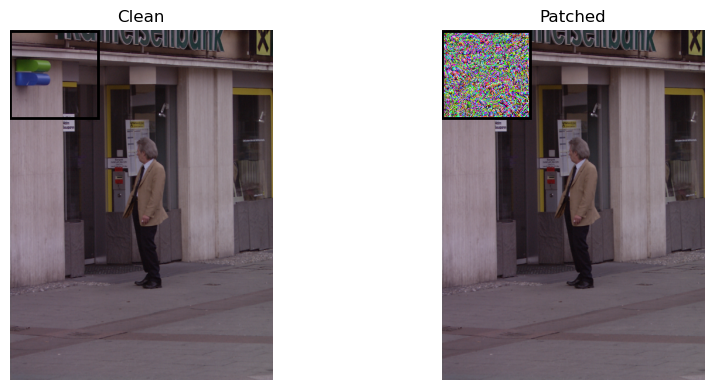

In [14]:
yolo = load_ultralytics_yolo("yolo11s.pt")
clean_pil = Image.open("data/person_012.png")
patch_pil = Image.open("data/patch.png")
patch_xy = (0, 0)

report = analyze_yolo_patch_pair(
    clean_pil, patch_pil, yolo,
    patch_xy=patch_xy,
    imgsz=640,
    conf=0.25,
    iou_nms=0.45,
    match_iou=0.5,
    pre_conf=0.001,
    pre_max_det=30000,
    max_det=300,
    class_aware_nms=True,
    device=None,
    enable_detect_feature_compare=True,
)

pretty_print_diagnosis(report)

patched_pil, patch_bbox, _ = apply_patch_to_image(clean_pil, patch_pil, patch_xy)
show_patch_bbox(pil_to_torch_rgb01(clean_pil), pil_to_torch_rgb01(patched_pil), patch_bbox)


=== Patch region ===
bbox=[0.0, 0.0, 160.0, 160.0]  area_ratio=0.062500  area_px=25600

=== Post-NMS counts ===
clean: 2  patched: 2

=== Lure stats (patched candidates) ===
{'patch_bbox': [0.0, 0.0, 160.0, 160.0], 'topK': 295, 'frac_topK_centers_in_patch': 0.8949152827262878, 'max_score_in_patch': 0.33999747037887573, 'num_candidates_total': 295, 'num_candidates_in_patch': 264}

=== Feature similarity (Detect inputs) ===
{'object_roi': {'target_clean_post_idx': 0, 'cosine_per_scale': [1.0, 0.9999999403953552, 1.0000001192092896]}, 'patch_roi': {'cosine_per_scale': [0.9999996423721313, 0.9999998807907104, 1.0000001192092896]}}

=== Per-target diagnosis (clean post-NMS objects) ===
- clean#0 cls=32 score=0.340 status=matched diagnosis=kept_after_patch
- clean#1 cls=0 score=0.285 status=matched diagnosis=kept_after_patch


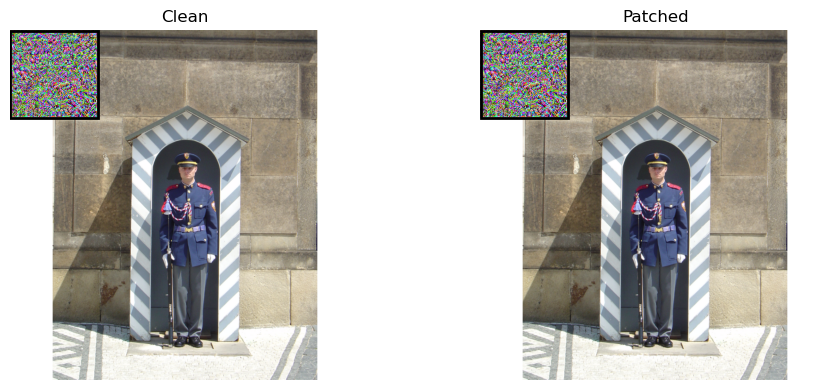

In [15]:
yolo = load_ultralytics_yolo("yolo11s.pt")
clean_pil = Image.open("data/crop001602_patched_lu.png")
patch_pil = Image.open("data/patch.png")
patch_xy = (0, 0)

report = analyze_yolo_patch_pair(
    clean_pil, patch_pil, yolo,
    patch_xy=patch_xy,
    imgsz=640,
    conf=0.25,
    iou_nms=0.45,
    match_iou=0.5,
    pre_conf=0.001,
    pre_max_det=30000,
    max_det=300,
    class_aware_nms=True,
    device=None,
    enable_detect_feature_compare=True,
)

pretty_print_diagnosis(report)

patched_pil, patch_bbox, _ = apply_patch_to_image(clean_pil, patch_pil, patch_xy)
show_patch_bbox(pil_to_torch_rgb01(clean_pil), pil_to_torch_rgb01(patched_pil), patch_bbox)
